# Advanced Graph - Notebook Example

Demonstrate how to use MLRun Graphs and its advanced functionality including:
* **Use of flow, task, model, and ensemble router states**
* **Build tasks from custom handlers, classes and storey components**
* **Use custom error handlers**
* **Test graphs locally**
* **Deploy the graph as a real-time serverless functions**


In [1]:
import mlrun

## Define functions and classes (used in our graph)

In [2]:
from cloudpickle import load
from typing import List
from sklearn.datasets import load_iris
import numpy as np

# model serving class example
class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

# echo class, custom class example
class Echo:
    def __init__(self, context, name=None, **kw):
        self.context = context
        self.name = name
        self.kw = kw
        
    def do(self, x):
        print("Echo:", self.name, x)
        return x

# error echo function, demo catching error and using custom function
def error_catcher(x):
        x.body = {"body": x.body, "origin_state": x.origin_state, "error": x.error}
        print("EchoError:", x)
        return None

In [3]:
# mark the end of the code section, DO NOT REMOVE !
# nuclio: end-code

## Create a new serving function and graph
Use `code_to_function` to convert the code (above) into a serving function object and initialize a graph with async flow topology

In [4]:
function = mlrun.code_to_function("advanced", kind="serving", 
                                  image="mlrun/mlrun",
                                  requirements=['storey'])
graph = function.set_topology("flow", engine="async")
#function.verbose = True

Specify the sklearn models that will be used in the ensemble

In [5]:
models_path = 'https://s3.wasabisys.com/iguazio/models/iris/model.pkl'
path1 = models_path
path2 = models_path

Build and connect the graph (DAG) using the custom function and classes and plot the result. we add states 
using the `state.to()` method (will add a new state after the current one), or using the 
`graph.add_step()` method.

We use the `graph.error_handler()` (apply to all states) or `state.error_handler()` (apply to a specific state) if we want the error from the graph or the state to be fed into a specific state (catcher)

We can specify which state is the responder (returns the HTTP response) using the `state.respond()` method.
If we don't specify the responder the graph will be non-blocking.

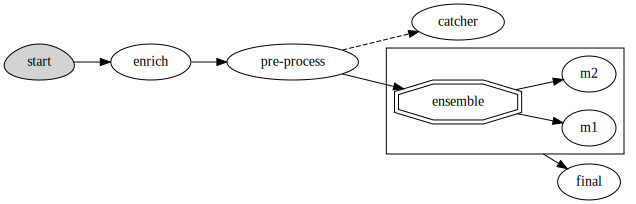

In [6]:
# use built-in storey class or our custom Echo class to create and link Task states
graph.to("storey.Extend", name="enrich", _fn='({"tag": "something"})') \
     .to(class_name="Echo", name="pre-process", some_arg='abc').error_handler("catcher")

# add an Ensemble router with two child models (routes), the "*" prefix mark it is a router class
router = graph.add_step("*mlrun.serving.VotingEnsemble", name="ensemble", after="pre-process")
router.add_route("m1", class_name="ClassifierModel", model_path=path1)
router.add_route("m2", class_name="ClassifierModel", model_path=path2)

# add the final step (after the router) which handles post processing and respond to the client
graph.add_step(class_name="Echo", name="final", after="ensemble").respond()

# add error handling state, run only when/if the "pre-process" state fail (keep after="")  
graph.add_step(handler="error_catcher", name="catcher", full_event=True, after="")

# plot the graph (using Graphviz) and run a test
graph.plot(rankdir='LR')

## Test our function locally
create a test set

In [7]:
import random
iris = load_iris()
x = random.sample(iris['data'].tolist(), 5)

create a mock server (simulator) and test the graph with our test data.

> Note: The model and router objects support a common serving protocol API, see the [protocol and API section](model-api.md)

In [8]:
server = function.to_mock_server()
resp = server.test("/v2/models/infer", body={"inputs": x})
server.wait_for_completion()
resp

> 2021-01-09 22:49:26,365 [info] model m1 was loaded
> 2021-01-09 22:49:26,493 [info] model m2 was loaded
> 2021-01-09 22:49:26,494 [info] Loaded ['m1', 'm2']
Echo: pre-process {'inputs': [[6.9, 3.2, 5.7, 2.3], [6.4, 2.7, 5.3, 1.9], [4.9, 3.1, 1.5, 0.1], [7.3, 2.9, 6.3, 1.8], [5.4, 3.7, 1.5, 0.2]], 'tag': 'something'}
Echo: final {'model_name': 'ensemble', 'outputs': [2, 2, 0, 2, 0], 'id': '0ebcc5f6f4c24d4d83eb36391eaefb98'}


{'model_name': 'ensemble',
 'outputs': [2, 2, 0, 2, 0],
 'id': '0ebcc5f6f4c24d4d83eb36391eaefb98'}

## Deploy the graph as a real-time serverless function

In [9]:
function.deploy()

> 2021-01-09 22:49:40,088 [info] Starting remote function deploy
2021-01-09 22:49:40  (info) Deploying function
2021-01-09 22:49:40  (info) Building
2021-01-09 22:49:40  (info) Staging files and preparing base images
2021-01-09 22:49:40  (info) Building processor image
2021-01-09 22:49:41  (info) Build complete
2021-01-09 22:49:47  (info) Function deploy complete
> 2021-01-09 22:49:48,422 [info] function deployed, address=default-tenant.app.yh55.iguazio-cd0.com:32222


'http://default-tenant.app.yh55.iguazio-cd0.com:32222'

<b>Invoke our remote function using the test data</b>

In [12]:
function.invoke("/v2/models/infer", body={"inputs": x})

{'model_name': 'ensemble',
 'outputs': [1, 2, 0, 0, 0],
 'id': '0ebcc5f6f4c24d4d83eb36391eaefb98'}